# Multi-class classification model

Using the following pipeline for the multi-class classifier model. 

0. Before we even think about training the model there is still some task-specific preprocessing to do:
- group the exploded df back again to have multiple tickers (The exploded dataframe where usefull during the EDA, but could confuse the model during traing if there are tweets that are exactly the same beloning to differnrt companies)
- create a binary multi-label vector and integrate it into the df (for the classification to work smoothly)
- exclude information irrelevant for the task at hand. (Voluntary, less clutter)

1. Split the data into train, val and test set 
2. Load data into dataloaders
3. Define the model
4. Train the model
5. Evaluate and visualize training
5. fine tune the model


# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from torch.utils.data import DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np      
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import hamming_loss, jaccard_score, f1_score, accuracy_score



d:\CODE\Deep_ml_project\AI-financial-sentiment-prediction\venv\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Preprocessing

In [2]:

# Load the balanced dataset and group it. Extract the tickers from the tweets.
df_exploded = pd.read_csv('data/processed/balanced_tweets_stock_data.csv')


df_grouped = (
    df_exploded.groupby("Tweet")["Ticker"]
    .apply(lambda x: list(set(x.dropna())))
    .reset_index()
)

unique_tickers = sorted(set( t for list in df_grouped['Ticker'] for t in list))
print(unique_tickers)

# Binary multi-label matrix
for t in unique_tickers:
    df_grouped[t] = df_grouped['Ticker'].apply(lambda lst: int (t in lst))

# drop the ticker column
df_grouped = df_grouped.drop(columns=['Ticker'])

print(df_grouped.head())

df_grouped.to_csv('data/processed/df_grouped.csv', index=False)



['AAPL', 'AMD', 'AMZN', 'BA', 'COST', 'DIS', 'GOOG', 'KO', 'META', 'MSFT', 'NFLX', 'NIO', 'Other', 'PG', 'PYPL', 'TSLA']
                                               Tweet  AAPL  AMD  AMZN  BA  \
0  " Why own this over $GOOG "\n\nis why every st...     0    0     0   0   
1  "70% of the top 100 unicorns run on Google Clo...     0    0     0   0   
2  "A designated driver has been ordered by a Chi...     0    0     0   0   
3  "Amazon took 13 years to migrate from Oracle t...     0    0     1   0   
4  "Apple Pay has surpassed $PYPL Venmo and the $...     0    0     0   0   

   COST  DIS  GOOG  KO  META  MSFT  NFLX  NIO  Other  PG  PYPL  TSLA  
0     0    0     1   0     0     0     0    0      0   0     0     0  
1     0    0     1   0     0     0     0    0      0   0     0     0  
2     0    0     0   0     0     0     0    0      0   0     0     1  
3     0    0     0   0     0     0     0    0      0   0     0     0  
4     0    0     0   0     0     0     0    0      0   0     

## Split the data and create a dataset

In [3]:
# Stratified split for multi-class classification
X = df_grouped["Tweet"].values
y = df_grouped[unique_tickers].values  # binary matrix

# 1. Split 30% temp (for val + test)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(msss.split(X, y))

X_train, y_train = X[train_idx], y[train_idx]
X_temp,  y_temp  = X[temp_idx],  y[temp_idx]

# 2. Split that temp 30% into 15% val + 15% test
msss_valtest = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(msss_valtest.split(X_temp, y_temp))

X_val, y_val   = X_temp[val_idx],  y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]



class TweetDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.Tweets = X
        self.labels = torch.tensor(y, dtype=torch.float)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.Tweets) # nr of tweets in the dataset

    def __getitem__(self, idx):
        tweet = str(self.Tweets[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt")

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}   # remove the batch dimension (autogenerated by the tokenizer)
        encoding['labels'] = label  # add the labels to the encoding
        return encoding
    
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
lengths = [len(tokenizer.encode(tweet)) for tweet in X_train]  # ← Returns a LIST of numbers
max_len = int(np.percentile(lengths, 95)) 

train_dataset = TweetDataset(X_train, y_train, tokenizer, max_len)
val_dataset = TweetDataset(X_val, y_val, tokenizer, max_len)
test_dataset = TweetDataset(X_test, y_test, tokenizer, max_len)


It looks like there is not much data, but in reality what this means is that each tweet mentions on average about 60000/12000 = 5 stocks, should be aight. 

In [4]:
nr_labels = len(unique_tickers)
print(nr_labels)


## Experiment with hyperparameter tuning with Optuna wrapper later on??

# Define the model, starting with the hugging face API model. Might change later in depending on time and resutls
model = AutoModelForSequenceClassification.from_pretrained(
    'vinai/bertweet-base',
    num_labels=nr_labels,
    problem_type="multi_label_classification"   
)
for param in model.base_model.parameters():  # Freeze the base model parameters, train only the head
    param.requires_grad = False

for layer in model.base_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Check how many parameters are trainable
trainable, total = 0, 0
for _, p in model.named_parameters():
    total += p.numel()
    if p.requires_grad:
        trainable += p.numel()

print(f"Trainable parameters: {trainable}/{total} ({100*trainable/total:.2f}%)")

# Define training arguments for the model. Starting with baseline huggingface parameters.
training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=64,  # the huggingface trainer API handles the dataloaders for us, we just specify the batch size
        per_device_eval_batch_size=64,
        num_train_epochs=30,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none"
        
)


# Define the metrics for the model
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    probs = 1 / (1 + np.exp(-logits))  # Using sigmoid to get probabilities, works with any logits
    preds = (probs > 0.205).astype(int)  # Using 0.5 as threshold
    f1 = f1_score(labels, preds, average= "macro", zero_division=0)  # Checking the macro F1 score
    acc = accuracy_score(labels, preds) 
    return {"f1": f1, "acc": acc}

# Define the trainer using huggingfaces API
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] 
)


16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Carl\AppData\Local\Temp\ipykernel_39972\646440637.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainable parameters: 14778640/134912272 (10.95%)


## Train the model head

In [5]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# print(f"Using device: {device}")
# trainer.train()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

model.to(device)
trainer.train()

Using CUDA: NVIDIA GeForce RTX 2080
Available memory: 8.00 GB


Epoch,Training Loss,Validation Loss,F1,Acc
1,No log,0.255300,0.033271,0.260111
2,No log,0.198340,0.278452,0.380162
3,0.262000,0.142927,0.486763,0.541507
4,0.262000,0.108694,0.547111,0.693912
5,0.262000,0.087937,0.593441,0.757344
6,0.113700,0.076259,0.650549,0.769264
7,0.113700,0.067575,0.658914,0.789698
8,0.113700,0.061394,0.694911,0.793955
9,0.072700,0.056228,0.717221,0.805875
10,0.072700,0.054158,0.716012,0.798212


TrainOutput(global_step=5017, training_loss=0.07217378278450588, metrics={'train_runtime': 1857.3651, 'train_samples_per_second': 178.301, 'train_steps_per_second': 2.794, 'total_flos': 1.842762971977267e+16, 'train_loss': 0.07217378278450588, 'epoch': 29.0})

## PLotting the training and validation curves

Train entries: 10
Eval entries: 29


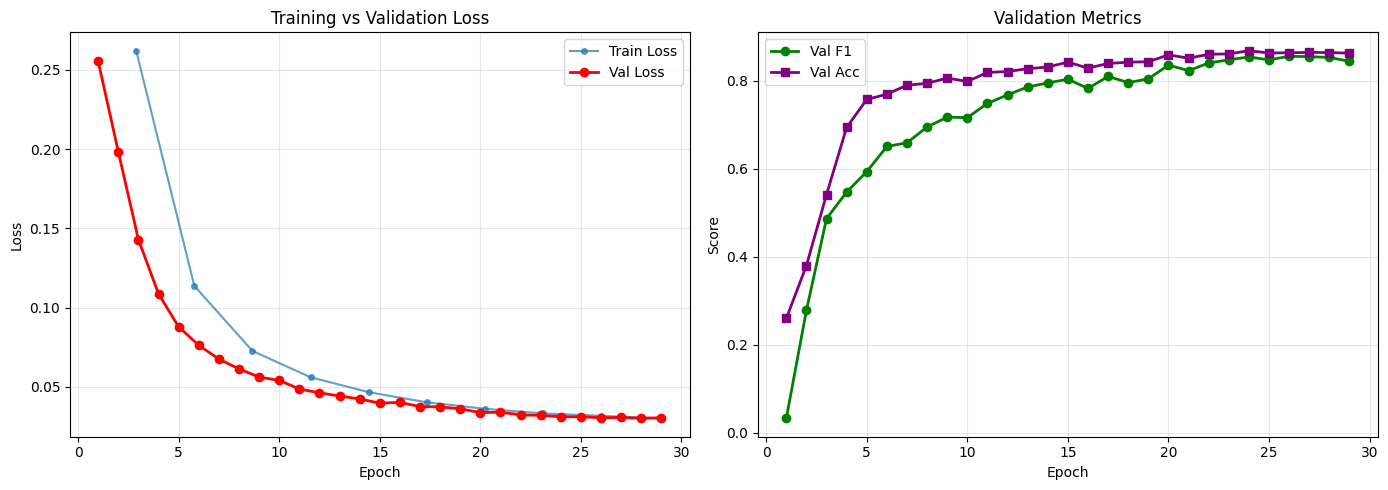

In [9]:
import json
import matplotlib.pyplot as plt

checkpoint_path = './results/checkpoint-5017'
with open(f'{checkpoint_path}/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

history = trainer_state['log_history']

# Separate training and evaluation entries

train_entries = [entry for entry in history if 'loss' in entry and 'eval_loss' not in entry]
eval_entries = [entry for entry in history if 'eval_loss' in entry]

# Extract training data
train_steps = [entry['step'] for entry in train_entries]
train_losses = [entry['loss'] for entry in train_entries]
train_epochs = [entry['epoch'] for entry in train_entries]

# Extract evaluation data
eval_steps = [entry['step'] for entry in eval_entries]
eval_epochs = [entry['epoch'] for entry in eval_entries]
eval_losses = [entry['eval_loss'] for entry in eval_entries]
eval_f1s = [entry['eval_f1'] for entry in eval_entries]
eval_accs = [entry['eval_acc'] for entry in eval_entries]

print(f"Train entries: {len(train_entries)}")
print(f"Eval entries: {len(eval_entries)}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(train_epochs, train_losses, 'o-', alpha=0.7, label='Train Loss', markersize=4)
axes[0].plot(eval_epochs, eval_losses, 'o-', linewidth=2, label='Val Loss', color='red', markersize=6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics curve
axes[1].plot(eval_epochs, eval_f1s, 'o-', linewidth=2, label='Val F1', color='green', markersize=6)
axes[1].plot(eval_epochs, eval_accs, 's-', linewidth=2, label='Val Acc', color='purple', markersize=6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_curves.png', dpi=150)
plt.show()

## Validating performance on the test set

In [11]:


# Load your saved model
model_path = './results/checkpoint-5017'  # or wherever your best model is
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')

# Set device
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Define training arguments for the finished model.
training_args_test = TrainingArguments(
        output_dir='./test_results',
        save_strategy = "epoch",
        per_device_train_batch_size=16,  # the huggingface trainer API handles the dataloaders for us, we just specify the batch size
        do_train=False,
        do_eval=False,
        do_predict=True,
)

# Create a NEW trainer with the loaded model
trainer_test = Trainer(
    model=model,
    args=training_args_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Reuse the same compute_metrics function from Cell 9
)

# Test set
predictions = trainer.predict(test_dataset)

# Get metrics
print("Test Results:")
print(f"Loss: {predictions.metrics['test_loss']:.4f}")
print(predictions.metrics)




C:\Users\Carl\AppData\Local\Temp\ipykernel_39972\2187936487.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_test = Trainer(


Test Results:
Loss: 0.0319
{'test_loss': 0.03194036707282066, 'test_f1': 0.8673206244667225, 'test_acc': 0.8556218057921635, 'test_runtime': 10.4969, 'test_samples_per_second': 223.685, 'test_steps_per_second': 3.525}


In [12]:

# Convert predictions to binary format (apply sigmoid threshold)
# For multi-label, use sigmoid + threshold
preds_probs = torch.sigmoid(torch.tensor(predictions.predictions))
preds_binary = (preds_probs > 0.205).int().numpy()  # Threshold at 0.5

labels = predictions.label_ids

# Calculate multi-label metrics
print("=== Test Set Results (Multi-Label) ===")
print(f"Test Loss: {predictions.metrics['test_loss']:.4f}")
print(f"Hamming Loss: {hamming_loss(labels, preds_binary):.4f}")
print(f"Jaccard Score: {jaccard_score(labels, preds_binary, average='samples'):.4f}")
print(f"F1 Score (micro): {f1_score(labels, preds_binary, average='micro'):.4f}")
print(f"F1 Score (macro): {f1_score(labels, preds_binary, average='macro'):.4f}")
print(f"F1 Score (samples): {f1_score(labels, preds_binary, average='samples'):.4f}")

# Subset accuracy (exact match - all labels correct)
subset_acc = accuracy_score(labels, preds_binary)
print(f"Subset Accuracy (exact match): {subset_acc:.4f}")


# Get per-stock F1 scores
per_stock_f1 = f1_score(labels, preds_binary, average=None)
stock_names = ['AAPL', 'AMD', 'AMZN', ...]  # your 25 stocks in order

for stock, f1 in zip(stock_names, per_stock_f1):
    print(f"{stock}: F1 = {f1:.4f}")

=== Test Set Results (Multi-Label) ===
Test Loss: 0.0319
Hamming Loss: 0.0129
Jaccard Score: 0.9321
F1 Score (micro): 0.9293
F1 Score (macro): 0.8673
F1 Score (samples): 0.9529
Subset Accuracy (exact match): 0.8556
AAPL: F1 = 0.9335
AMD: F1 = 0.9595
AMZN: F1 = 0.9457
Ellipsis: F1 = 0.8444


In [ ]:
# Get per-stock F1 scores
per_stock_f1 = f1_score(labels, preds_binary, average=None)

# Your stock list (in the same order as your columns)
# stock_names = ['AAPL', 'AMD', 'AMZN', 'BA', 'BX', 'COST', 'CRM', 'DIS', 
#                'ENPH', 'F', 'GOOG', 'INTC', 'KO', 'META', 'MSFT', 'NFLX', 
#                'NIO', 'NOC', 'PG', 'PYPL', 'TSLA', 'TSM', 'VZ', 'XPEV', 'ZS']

stock_names = unique_tickers

print("=== Per-Stock F1 Scores ===")
print(f"{'Stock':<6} {'F1 Score':<10} {'Bar'}")
print("-" * 40)

# Sort by F1 score for easier reading
stock_f1_pairs = sorted(zip(stock_names, per_stock_f1), key=lambda x: x[1], reverse=True)

for stock, f1 in stock_f1_pairs:
    bar = '█' * int(f1 * 50)
    print(f"{stock:<6} {f1:>6.4f}     {bar}")

# Summary
print("\n=== Summary ===")
print(f"Best performing: {stock_f1_pairs[0][0]} (F1: {stock_f1_pairs[0][1]:.4f})")
print(f"Worst performing: {stock_f1_pairs[-1][0]} (F1: {stock_f1_pairs[-1][1]:.4f})")
print(f"Stocks with F1 > 0.8: {sum(1 for _, f1 in stock_f1_pairs if f1 > 0.8)}/25")
print(f"Stocks with F1 < 0.5: {sum(1 for _, f1 in stock_f1_pairs if f1 < 0.5)}/25")

=== Per-Stock F1 Scores ===
Stock  F1 Score   Bar
----------------------------------------
INTC   0.9868     █████████████████████████████████████████████████
MSFT   0.9856     █████████████████████████████████████████████████
GOOG   0.9800     ████████████████████████████████████████████████
NFLX   0.9608     ████████████████████████████████████████████████
AMD    0.9595     ███████████████████████████████████████████████
F      0.9536     ███████████████████████████████████████████████
AMZN   0.9457     ███████████████████████████████████████████████
AAPL   0.9335     ██████████████████████████████████████████████
CRM    0.9297     ██████████████████████████████████████████████
COST   0.8929     ████████████████████████████████████████████
BA     0.8444     ██████████████████████████████████████████
ENPH   0.7907     ███████████████████████████████████████
KO     0.7731     ██████████████████████████████████████
DIS    0.7033     ███████████████████████████████████
META   0.6250     

In [14]:
# Count how often each stock is predicted
preds_sum = preds_binary.sum(axis=0)  # How many times each stock was predicted
labels_sum = labels.sum(axis=0)       # How many times each stock actually appears

print("=== Prediction Distribution vs True Distribution ===")
print(f"{'Stock':<6} {'Predicted':<10} {'Actual':<10} {'Diff':<10} {'Prediction Rate'}")
print("-" * 60)

for i, stock in enumerate(stock_names):
    diff = preds_sum[i] - labels_sum[i]
    pred_rate = preds_sum[i] / len(labels)
    actual_rate = labels_sum[i] / len(labels)
    print(f"{stock:<6} {preds_sum[i]:<10} {labels_sum[i]:<10} {diff:>+6}     {pred_rate:.1%} (actual: {actual_rate:.1%})")

# Check TSLA specifically
tsla_idx = stock_names.index('TSLA')
print(f"\n=== TSLA Analysis ===")
print(f"TSLA predicted: {preds_sum[tsla_idx]} times ({preds_sum[tsla_idx]/len(labels)*100:.1f}%)")
print(f"TSLA actual: {labels_sum[tsla_idx]} times ({labels_sum[tsla_idx]/len(labels)*100:.1f}%)")
print(f"Over-predicted by: {preds_sum[tsla_idx] - labels_sum[tsla_idx]} instances")

=== Prediction Distribution vs True Distribution ===
Stock  Predicted  Actual     Diff       Prediction Rate
------------------------------------------------------------
AAPL   500        447.0       +53.0     21.3% (actual: 19.0%)
AMD    229        215.0       +14.0     9.8% (actual: 9.2%)
AMZN   435        394.0       +41.0     18.5% (actual: 16.8%)
BA     47         43.0         +4.0     2.0% (actual: 1.8%)
BX     69         42.0        +27.0     2.9% (actual: 1.8%)
COST   89         79.0        +10.0     3.8% (actual: 3.4%)
CRM    136        120.0       +16.0     5.8% (actual: 5.1%)
DIS    58         33.0        +25.0     2.5% (actual: 1.4%)
ENPH   49         37.0        +12.0     2.1% (actual: 1.6%)
F      168        155.0       +13.0     7.2% (actual: 6.6%)
GOOG   227        222.0        +5.0     9.7% (actual: 9.5%)
INTC   305        299.0        +6.0     13.0% (actual: 12.7%)
KO     240        192.0       +48.0     10.2% (actual: 8.2%)
META   30         18.0        +12.0     1.3

IndexError: index 16 is out of bounds for axis 0 with size 16

## Sove model configuration

In [16]:
# Save model config
model_config = {
    'model_path': './results/checkpoint-5017',
    'threshold': 0.205,
    'metrics': {
        'macro_f1': 0.5758,
        'micro_f1': 0.9015,
        'subset_accuracy': 0.8138
    }
}

import json
with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

In [17]:
def predict_stocks(tweet_text, model, tokenizer, threshold=0.205):
    """Predict which stocks are mentioned in a tweet"""
    
    # Get device from model
    device = next(model.parameters()).device
    
    # Tokenize
    inputs = tokenizer(tweet_text, return_tensors='pt', truncation=True, max_length=128)
    
    # Move inputs to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get probabilities
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)[0]
    
    # Move back to CPU for numpy conversion
    probs = probs.cpu()
    
    # Apply threshold
    predictions = (probs > threshold).int().numpy()
    
    # Get predicted stock names
    predicted_stocks = [stock_names[i] for i, pred in enumerate(predictions) if pred == 1]
    
    return predicted_stocks, probs.numpy()

# Make sure model is on correct device first
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Example usage
tweet = "Tesla and Apple crushing it! $TSLA $AAPL"
# Now predict
stocks, probs = predict_stocks(tweet, model, tokenizer, threshold=0.205)
print(f"Predicted stocks: {stocks}")

Predicted stocks: ['AAPL', 'NFLX']
